# SimNet Training for Balancing Robot

This notebook trains a SimNet model using both physics simulation data and real-world data.

In [1]:
# Uncomment the following lines to run in Google Colab

# %cd /content
# !git clone https://github.com/EyalPorat/ddpg-balancing-robot.git
# %cd ddpg-balancing-robot
# !git checkout simpler-state
# %cd /content/ddpg-balancing-robot/python/notebooks

# import sys
# sys.path.append('/content/ddpg-balancing-robot/python')  # Add the repo root to Python path

In [2]:
import sys
sys.path.append('..')

import torch
import numpy as np
from pathlib import Path
import json
import yaml
import glob
from matplotlib import pyplot as plt
import seaborn as sns

from src.balancing_robot.models import SimNet
from src.balancing_robot.environment import BalancerEnv
from src.balancing_robot.training import SimNetTrainer
from src.balancing_robot.visualization import plot_predictions_comparison

## Load Configuration

In [3]:
# Load configurations
with open('../configs/simnet_config.yaml', 'r') as f:
    simnet_config = yaml.safe_load(f)

with open('../configs/env_config.yaml', 'r') as f:
    env_config = yaml.safe_load(f)

# Create directories
log_dir = Path('logs/simnet_training')
log_dir.mkdir(parents=True, exist_ok=True)

## Initialize Models and Environment

In [4]:
# Set random seeds
torch.manual_seed(simnet_config['data_collection']['random_seed'])
np.random.seed(simnet_config['data_collection']['random_seed'])

# Create environment for physics data
env = BalancerEnv(config_path='../configs/env_config.yaml')

# Initialize trainer with config
trainer = SimNetTrainer(
    env=env,
    config_path='../configs/simnet_config.yaml'
)

c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## Collect and Process Physics Data

In [5]:
# Collect physics simulation data
train_data, val_data = trainer.collect_physics_data()

print(f"Collected {len(train_data['states'])} training samples")
print(f"Collected {len(val_data['states'])} validation samples")

Collected 816165 training samples
Collected 204041 validation samples


## Analyze Pre-Processed Data

Physics data distribution statistics:
  angle_range: (-1.7927, 1.7786)
  angle_mean: -0.0065
  angle_std: 0.7998
  angular_vel_range: (-22.9670, 22.2114)
  angular_vel_mean: 0.0013
  angular_vel_std: 4.3100
  num_samples: 816165.0000
  min_weight: 0.0000
  max_weight: 0.0000
  mean_weight: 0.0000
  std_weight: 0.0000


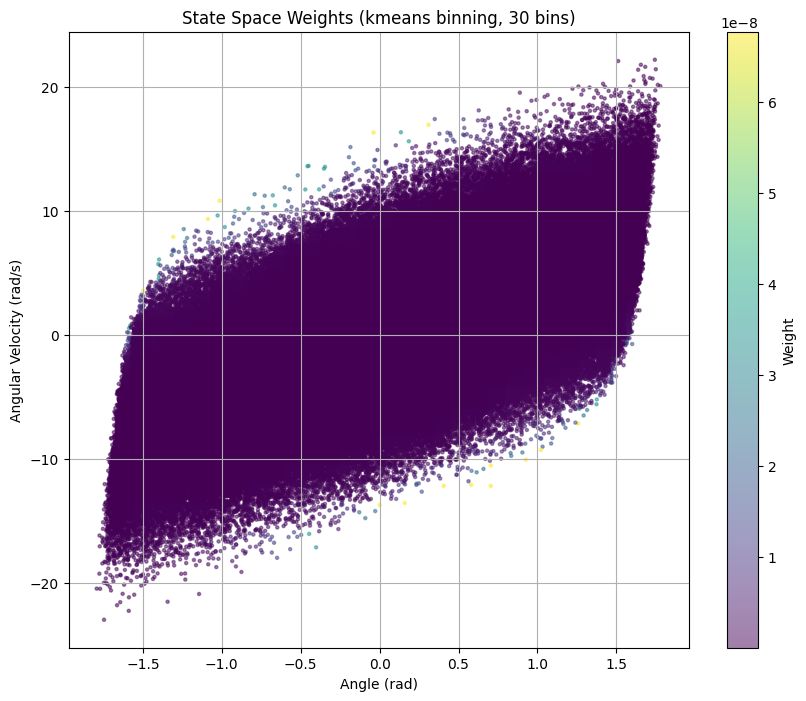

In [6]:
# Define class balancing parameters
num_bins = 30
strategy = "kmeans"

# Get distribution statistics
physics_distribution = SimNetTrainer.analyze_class_distribution(
    train_data, 
    num_bins=num_bins,
    strategy=strategy
)

print("Physics data distribution statistics:")
for key, value in physics_distribution.items():
    if isinstance(value, tuple):
        print(f"  {key}: ({value[0]:.4f}, {value[1]:.4f})")
    else:
        print(f"  {key}: {value:.4f}")

# Visualize class weights using angle and angular velocity
states = train_data['states']
weights = SimNetTrainer.calculate_class_weights(
    states, 
    num_bins=num_bins, 
    strategy=strategy
)

# Create weight heatmap
plt.figure(figsize=(10, 8))
plt.scatter(states[:, 0], states[:, 1], c=weights, cmap='viridis', alpha=0.5, s=5)
plt.colorbar(label='Weight')
plt.title(f'State Space Weights ({strategy} binning, {num_bins} bins)')
plt.xlabel('Angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid(True)
plt.savefig(log_dir / "class_weights_visualization.png")
plt.show()

## Balance Data and Analyze Again

In [7]:
# Create a balanced dataset through oversampling
# print("Creating balanced dataset through oversampling...")
# balanced_train_data = SimNetTrainer.create_balanced_dataset(
#     train_data, 
#     num_bins=num_bins, 
#     strategy=strategy
# )

# print(f"Original dataset size: {len(train_data['states'])} samples")
# print(f"Balanced dataset size: {len(balanced_train_data['states'])} samples")

# # Compare distributions
# plt.figure(figsize=(16, 6))

# plt.subplot(1, 2, 1)
# plt.scatter(train_data['states'][:, 0], train_data['states'][:, 1], alpha=0.1, s=1)
# plt.title('Original Training Data Distribution')
# plt.xlabel('Angle (rad)')
# plt.ylabel('Angular Velocity (rad/s)')
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.scatter(balanced_train_data['states'][:, 0], balanced_train_data['states'][:, 1], 
#             alpha=0.1, s=1, c='orange')
# plt.title('Balanced Training Data Distribution')
# plt.xlabel('Angle (rad)')
# plt.ylabel('Angular Velocity (rad/s)')
# plt.grid(True)

# plt.tight_layout()
# plt.savefig(log_dir / "balanced_vs_original_distribution.png")
# plt.show()

## Train on Physics Data

In [8]:
# Train on physics data
physics_history = trainer.train(
    # train_data=balanced_train_data,
    train_data=train_data,
    val_data=val_data,
    is_finetuning=False,
    log_dir=log_dir / 'physics'
)

Epoch 1/30 - Train Loss: 4.766934 - Val Loss: 2.359358
Epoch 2/30 - Train Loss: 1.533937 - Val Loss: 1.020135
Epoch 3/30 - Train Loss: 0.747954 - Val Loss: 0.526858
Epoch 4/30 - Train Loss: 0.382971 - Val Loss: 0.264970
Epoch 5/30 - Train Loss: 0.189989 - Val Loss: 0.128741
Epoch 6/30 - Train Loss: 0.091808 - Val Loss: 0.061792
Epoch 7/30 - Train Loss: 0.044617 - Val Loss: 0.030319
Epoch 8/30 - Train Loss: 0.022860 - Val Loss: 0.016144
Epoch 9/30 - Train Loss: 0.013007 - Val Loss: 0.009826
Epoch 10/30 - Train Loss: 0.008502 - Val Loss: 0.006959
Epoch 11/30 - Train Loss: 0.006370 - Val Loss: 0.005590
Epoch 12/30 - Train Loss: 0.005290 - Val Loss: 0.004846
Epoch 13/30 - Train Loss: 0.004689 - Val Loss: 0.004424
Epoch 14/30 - Train Loss: 0.004322 - Val Loss: 0.004146
Epoch 15/30 - Train Loss: 0.004073 - Val Loss: 0.003957
Epoch 16/30 - Train Loss: 0.003894 - Val Loss: 0.003799
Epoch 17/30 - Train Loss: 0.003757 - Val Loss: 0.003683
Epoch 18/30 - Train Loss: 0.003647 - Val Loss: 0.003589
E

In [9]:
# Save physics trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_physics_final.pt')

simnet_physics = SimNet(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.shape[0],
    hidden_dims=simnet_config['model']['hidden_dims']
)
simnet_physics.load_state_dict(torch.load(log_dir / 'simnet_physics_final.pt')['state_dict'])

<All keys matched successfully>

## Load and Process Real-World Data

In [10]:
# Find all files that start with robot_logs and end with .json
log_files = glob.glob('../data/robot_logs*.json')
print(f"Found {len(log_files)} log files: {log_files}")

# Initialize empty list to store all episodes
all_episodes = []

# Load and append data from each file
for log_file in log_files:
    with open(log_file, 'r') as f:
        log_data = json.load(f)
        # Append episodes from this file
        all_episodes.extend(log_data['episodes'])
        print(f"Loaded {len(log_data['episodes'])} episodes from {log_file}")

# Process combined data
real_train_data, real_val_data = trainer.process_real_data(all_episodes)
print(f"Processed {len(real_train_data['states'])} real training samples")
print(f"Processed {len(real_val_data['states'])} real validation samples")

Found 5 log files: ['../data\\robot_logs_20250308_205032_no_motor.json', '../data\\robot_logs_20250308_205436_with_motor.json', '../data\\robot_logs_20250309_132939_with_motor.json', '../data\\robot_logs_20250310_001210_with_motor.json', '../data\\robot_logs_20250310_001522_no_motor.json']
Loaded 40 episodes from ../data\robot_logs_20250308_205032_no_motor.json
Loaded 14 episodes from ../data\robot_logs_20250308_205436_with_motor.json
Loaded 22 episodes from ../data\robot_logs_20250309_132939_with_motor.json
Loaded 9 episodes from ../data\robot_logs_20250310_001210_with_motor.json
Loaded 27 episodes from ../data\robot_logs_20250310_001522_no_motor.json
Processed 8129 real training samples
Processed 2032 real validation samples


## Analyze and Balance Real-World Data Distribution

Real-world data distribution statistics:
  angle_range: (-0.7822, 0.7820)
  angle_mean: -0.0122
  angle_std: 0.1331
  angular_vel_range: (-8.7180, 8.6669)
  angular_vel_mean: -0.0019
  angular_vel_std: 1.6575
  num_samples: 8129.0000
  min_weight: 0.0000
  max_weight: 0.0000
  mean_weight: 0.0000
  std_weight: 0.0000


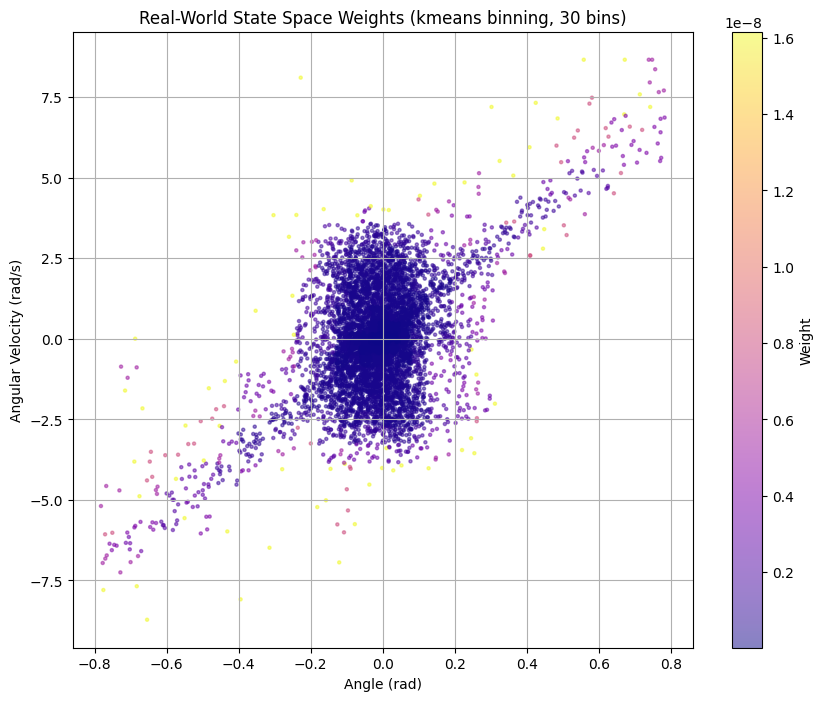

In [11]:
# Analyze the class distribution of real data
real_distribution = SimNetTrainer.analyze_class_distribution(
    real_train_data, 
    num_bins=num_bins, 
    strategy=strategy
)

print("Real-world data distribution statistics:")
for key, value in real_distribution.items():
    if isinstance(value, tuple):
        print(f"  {key}: ({value[0]:.4f}, {value[1]:.4f})")
    else:
        print(f"  {key}: {value:.4f}")

# Visualize class weights for real data
real_states = real_train_data['states']
real_weights = SimNetTrainer.calculate_class_weights(
    real_states, 
    num_bins=num_bins, 
    strategy=strategy
)

# Create weight heatmap for real data
plt.figure(figsize=(10, 8))
plt.scatter(real_states[:, 0], real_states[:, 1], c=real_weights, cmap='plasma', alpha=0.5, s=5)
plt.colorbar(label='Weight')
plt.title(f'Real-World State Space Weights ({strategy} binning, {num_bins} bins)')
plt.xlabel('Angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid(True)
plt.savefig(log_dir / "real_class_weights_visualization.png")
plt.show()

## Balance Real-World Data

Original real dataset size: 8129 samples
Balanced real dataset size: 306299 samples


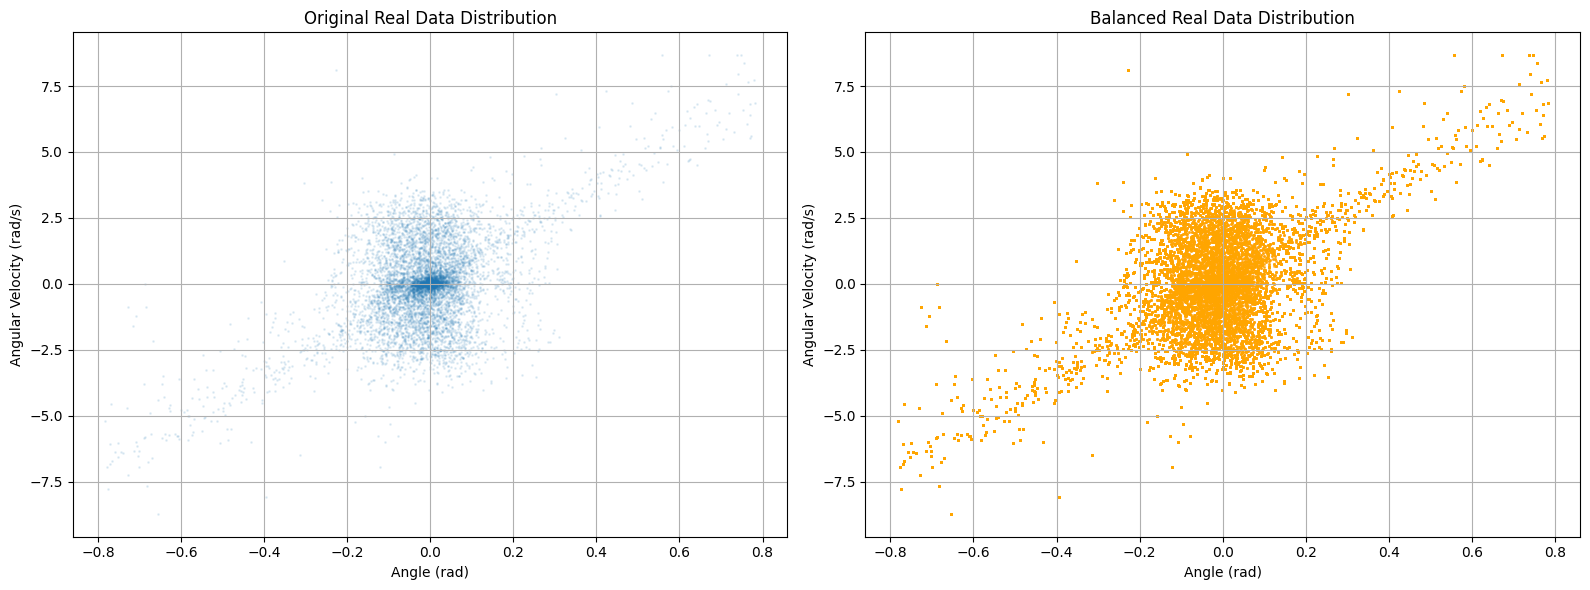

In [12]:
# Apply balancing to real data as well
balanced_real_train_data = SimNetTrainer.create_balanced_dataset(
    real_train_data, 
    num_bins=num_bins, 
    strategy=strategy
)

print(f"Original real dataset size: {len(real_train_data['states'])} samples")
print(f"Balanced real dataset size: {len(balanced_real_train_data['states'])} samples")

# Compare distributions
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(real_train_data['states'][:, 0], real_train_data['states'][:, 1], alpha=0.1, s=1)
plt.title('Original Real Data Distribution')
plt.xlabel('Angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(balanced_real_train_data['states'][:, 0], balanced_real_train_data['states'][:, 1], 
            alpha=0.1, s=1, c='orange')
plt.title('Balanced Real Data Distribution')
plt.xlabel('Angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid(True)

plt.tight_layout()
plt.savefig(log_dir / "balanced_real_vs_original_distribution.png")
plt.show()

## Fine-tune on Real Data

In [13]:
# Fine-tune on real data
real_history = trainer.train(
    train_data=balanced_real_train_data,
    val_data=real_val_data,
    is_finetuning=True,
    log_dir=log_dir / 'real'
)

Epoch 1/10 - Train Loss: 3.405106 - Val Loss: 1.278469
Epoch 2/10 - Train Loss: 2.879020 - Val Loss: 1.188312
Epoch 3/10 - Train Loss: 2.769526 - Val Loss: 1.154103
Epoch 4/10 - Train Loss: 2.723237 - Val Loss: 1.137034
Epoch 00035: reducing learning rate of group 0 to 2.5000e-06.
Epoch 5/10 - Train Loss: 2.694332 - Val Loss: 1.125360
Epoch 6/10 - Train Loss: 2.706504 - Val Loss: 1.113631
Epoch 7/10 - Train Loss: 2.682223 - Val Loss: 1.106621
Epoch 8/10 - Train Loss: 2.666576 - Val Loss: 1.100941
Epoch 9/10 - Train Loss: 2.654101 - Val Loss: 1.095828
Epoch 00040: reducing learning rate of group 0 to 1.2500e-06.
Epoch 10/10 - Train Loss: 2.642782 - Val Loss: 1.090927


## Compare Distributions Between Generated and Real Data

In [14]:
# # Create scatter plots and heatmaps to visualize the distribution of data
# plt.figure(figsize=(16, 12))

# # Original physics data distribution
# plt.subplot(2, 2, 1)
# plt.scatter(train_data['states'][:, 0], train_data['states'][:, 1], alpha=0.1, s=1)
# plt.title('Original Physics Data Distribution')
# plt.xlabel('Theta (rad)')
# plt.ylabel('Theta dot (rad/s)')
# plt.grid(True)

# # Original real data distribution
# plt.subplot(2, 2, 2)
# plt.scatter(real_train_data['states'][:, 0], real_train_data['states'][:, 1], alpha=0.2, s=3, c='orange')
# plt.title('Original Real-World Data Distribution')
# plt.xlabel('Theta (rad)')
# plt.ylabel('Theta dot (rad/s)')
# plt.grid(True)

# # Balanced physics data distribution
# plt.subplot(2, 2, 3)
# plt.scatter(balanced_train_data['states'][:, 0], balanced_train_data['states'][:, 1], alpha=0.1, s=1, c='green')
# plt.title('Balanced Physics Data Distribution')
# plt.xlabel('Theta (rad)')
# plt.ylabel('Theta dot (rad/s)')
# plt.grid(True)

# # Balanced real data distribution
# plt.subplot(2, 2, 4)
# plt.scatter(balanced_real_train_data['states'][:, 0], balanced_real_train_data['states'][:, 1], 
#             alpha=0.2, s=3, c='purple')
# plt.title('Balanced Real-World Data Distribution')
# plt.xlabel('Theta (rad)')
# plt.ylabel('Theta dot (rad/s)')
# plt.grid(True)

# plt.tight_layout()
# plt.savefig(log_dir / "comparison_original_vs_balanced.png")
# plt.show()

## Analyze Predictions

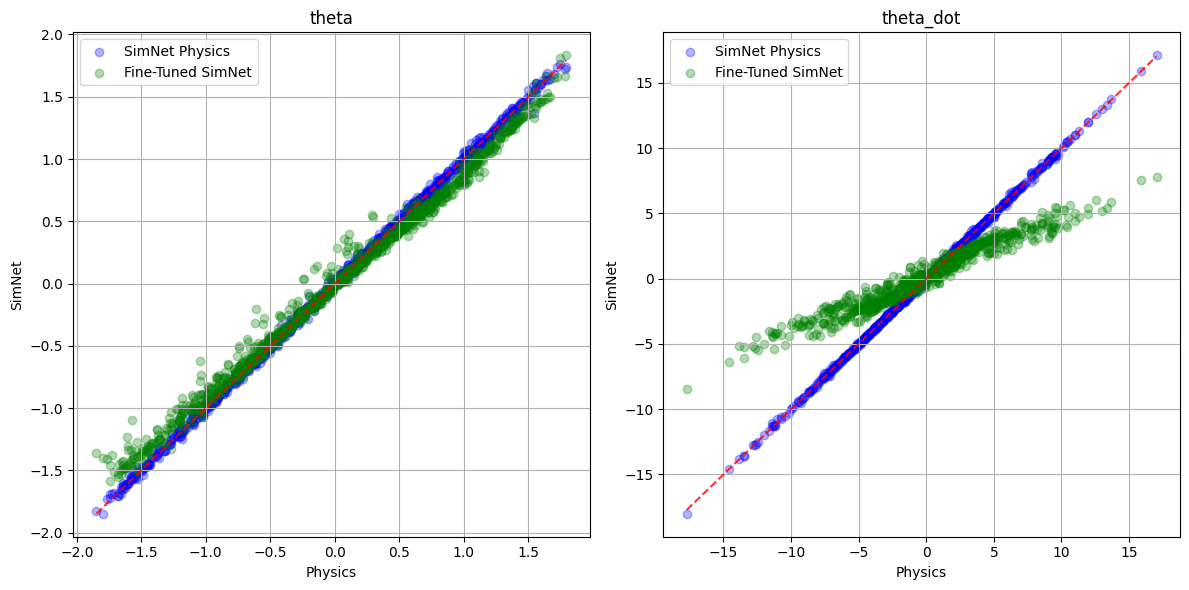

In [15]:

test_states = val_data["states"][:1000]
test_actions = val_data["actions"][:1000]
physics_preds = val_data["next_states"][:1000]  # The actual next states from the physics data

# Get SimNet predictions
simnet_preds = []
simnet_physics_preds = []
for s, a in zip(test_states, test_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    simnet_preds.append(pred_next)
    pred_next_physics = simnet_physics(s_tensor, a_tensor).detach().numpy()[0]
    simnet_physics_preds.append(pred_next_physics)
simnet_preds = np.array(simnet_preds)
simnet_physics_preds = np.array(simnet_physics_preds)

# Plot comparison (assuming your plot function looks something like this)
fig = plot_predictions_comparison(
    physics_preds=physics_preds,   # ground-truth next states
    simnet_preds=simnet_preds,     # network-predicted next states
    simnet_physics_preds=simnet_physics_preds,  # network-predicted next states using simnet physics model
    save_path=log_dir / "prediction_comparison.png"
)
plt.show()


## Evaluate Learning Curves

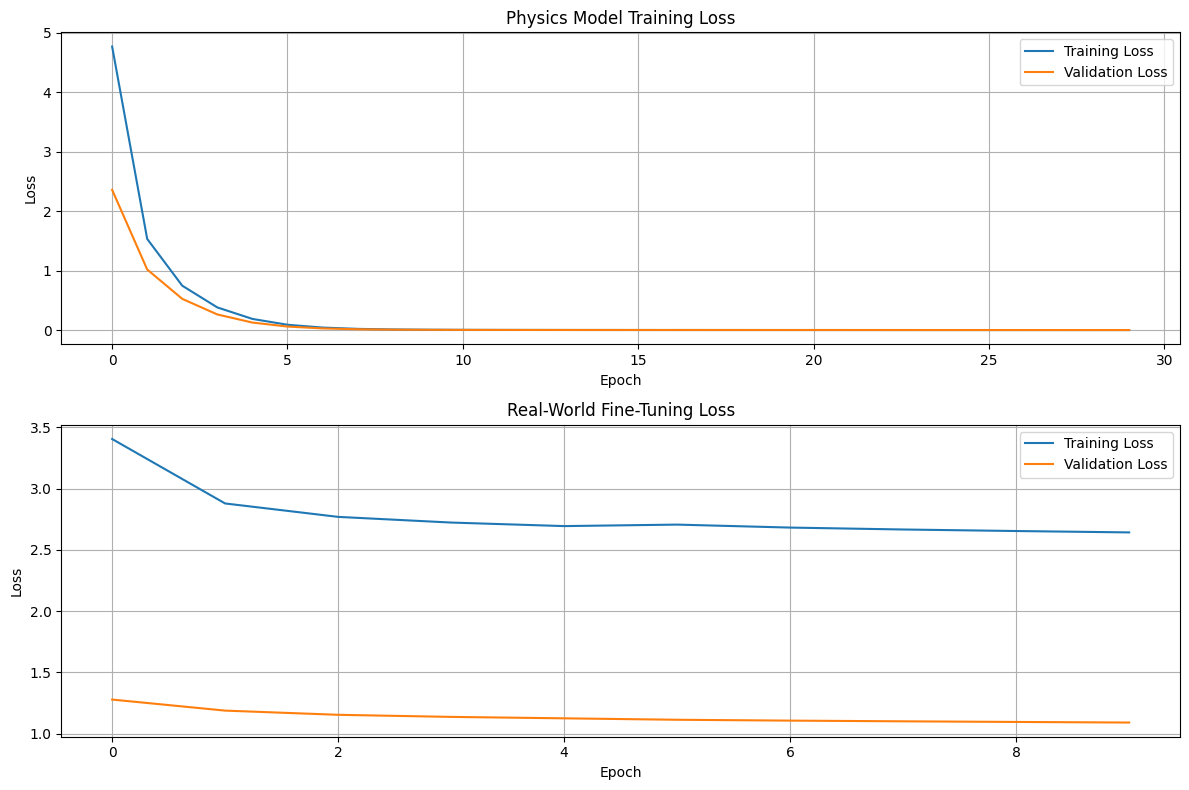

In [16]:
# Extract training losses from history data
physics_train_losses = [epoch['train_loss'] for epoch in physics_history]
physics_val_losses = [epoch['val_loss'] for epoch in physics_history]
real_train_losses = [epoch['train_loss'] for epoch in real_history]
real_val_losses = [epoch['val_loss'] for epoch in real_history]

# Create figure for loss plots
plt.figure(figsize=(12, 8))

# Plot physics training loss
plt.subplot(2, 1, 1)
plt.plot(physics_train_losses, label='Training Loss')
plt.plot(physics_val_losses, label='Validation Loss')
plt.title('Physics Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot real-world fine-tuning loss
plt.subplot(2, 1, 2)
plt.plot(real_train_losses, label='Training Loss')
plt.plot(real_val_losses, label='Validation Loss')
plt.title('Real-World Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(log_dir / "loss_curves.png")
plt.show()

## Evaluate Performance Across State-Space

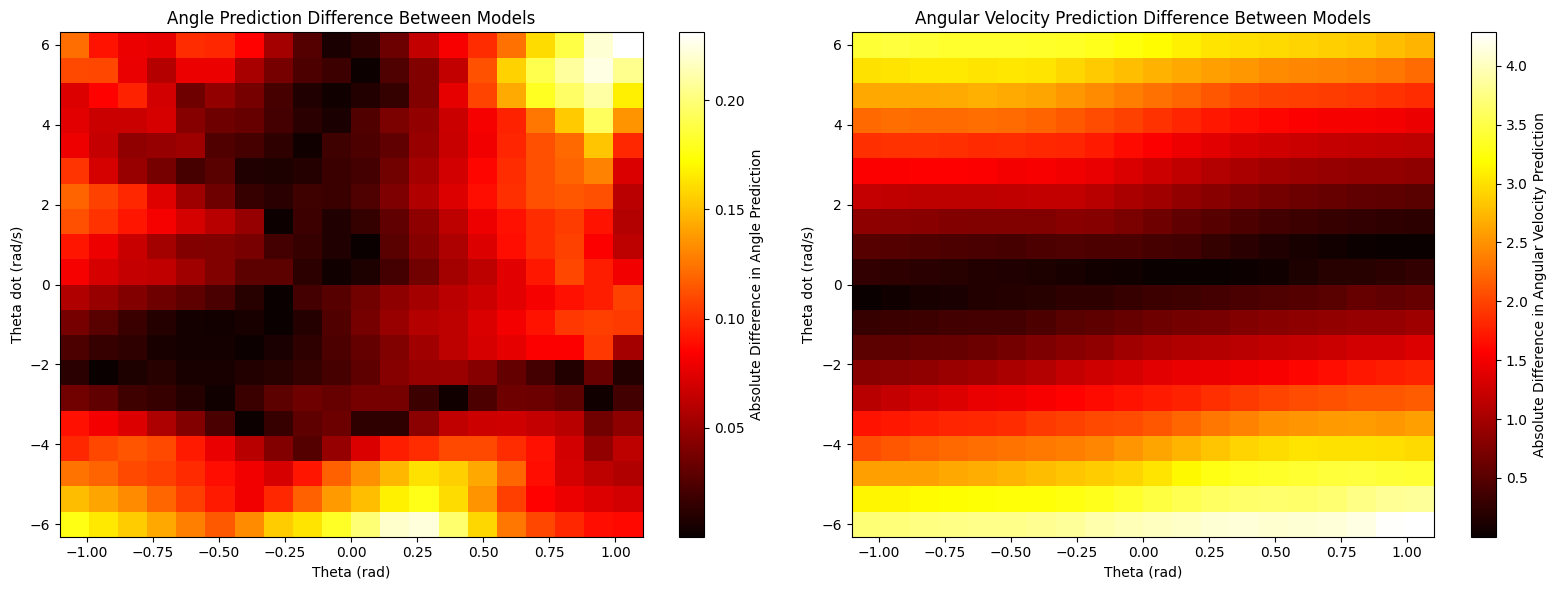

In [17]:
# Create a grid of test points across the state space
theta_range = np.linspace(-np.pi/3, np.pi/3, 20)
theta_dot_range = np.linspace(-6, 6, 20)
theta_grid, theta_dot_grid = np.meshgrid(theta_range, theta_dot_range)

# Flatten the grid
test_grid_states = np.column_stack((theta_grid.flatten(), theta_dot_grid.flatten()))

# Test both models on this grid with a zero action
test_grid_actions = np.zeros((len(test_grid_states), 1))

# Get predictions from both models
grid_simnet_preds = []
grid_simnet_physics_preds = []

for s, a in zip(test_grid_states, test_grid_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)
    
    # Get prediction from fine-tuned model
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    grid_simnet_preds.append(pred_next)
    
    # Get prediction from physics-only model
    pred_next_physics = simnet_physics(s_tensor, a_tensor).detach().numpy()[0]
    grid_simnet_physics_preds.append(pred_next_physics)

grid_simnet_preds = np.array(grid_simnet_preds)
grid_simnet_physics_preds = np.array(grid_simnet_physics_preds)

# Calculate the absolute difference between the models
prediction_diff = np.abs(grid_simnet_preds - grid_simnet_physics_preds)
diff_angle = prediction_diff[:, 0].reshape(theta_dot_grid.shape)
diff_angular_vel = prediction_diff[:, 1].reshape(theta_dot_grid.shape)

# Plot the difference as a heatmap
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(theta_grid, theta_dot_grid, diff_angle, cmap='hot')
plt.colorbar(label='Absolute Difference in Angle Prediction')
plt.title('Angle Prediction Difference Between Models')
plt.xlabel('Theta (rad)')
plt.ylabel('Theta dot (rad/s)')

plt.subplot(1, 2, 2)
plt.pcolormesh(theta_grid, theta_dot_grid, diff_angular_vel, cmap='hot')
plt.colorbar(label='Absolute Difference in Angular Velocity Prediction')
plt.title('Angular Velocity Prediction Difference Between Models')
plt.xlabel('Theta (rad)')
plt.ylabel('Theta dot (rad/s)')

plt.tight_layout()
plt.savefig(log_dir / "prediction_difference_heatmap.png")
plt.show()

## Save Final Model

In [18]:
# Save trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'real_history': real_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_final.pt')
